# Approach 1: Siamese architecture with Binary Cross Entropy Loss

In [3]:
"""
NOTE: This code was originally run with a private dataset from Company X.
Due to data privacy and confidentiality agreements, the actual data is not shared.
Please replace 'your_dataset' with your own data to run the script.
"""

"\nNOTE: This code was originally run with a private dataset from Company X.\nDue to data privacy and confidentiality agreements, the actual data cannot be shared.\nPlease replace 'your_dataset.csv' with your own data to run the script.\n"

In [7]:
#importing required libraries

import os
import glob2
import cv2
import numpy as np
import matplotlib.pyplot as plt
import itertools
import random
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import time
import sys
import torchvision
import torch.optim as optim
from tqdm import tqdm
from statistics import mean
import itertools
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from sklearn.metrics import accuracy_score , precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

In [8]:
random_seed = 2
torch.manual_seed(random_seed) 

In [9]:
# Main folder where the class wise images are stored in the respective folders
"""
Original dataset contains the typical semiconductor wafer defects. The defects are similar to the the types of defects 
found in the open source kaggle dataset : https://www.kaggle.com/datasets/qingyi/wm811k-wafer-map
"""

print(os.listdir("./your_dataset"))

['Donut', 'Scratch', 'Random', 'Edge-loc', 'Edge-ring', 'Center', 'Near-Full', 'None', 'Blacklist', 'Loc']


In [6]:
"""
Storing the path of each class in a variable with the class name.

"""

donut_path = "./Donut"
scratch_path = "./Scratch"
random_path = "./Random"
edgeloc_path = "./Edge-loc"
edgering_path = "./Edge-ring"
center_path = "./Center"
nearfull_path = "./Near-Full"
loc_path = "./Loc"
none_path = "./None"

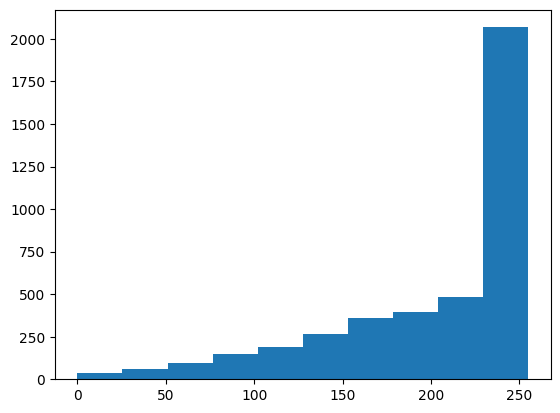

In [5]:
# Histogram of unnormalized pixels ranging from 0 - 255.

unnorm_img = cv2.imread(os.path.join(random_path,"9.png"))
unnorm_img = cv2.cvtColor(unnorm_img , cv2.COLOR_RGB2GRAY)
unnorm_img = np.array(unnorm_img)

pixels =[]
for i in range(64):
    for j in range(64):
        pixels.append(unnorm_img[i][j])


plt.hist(pixels)
plt.show()

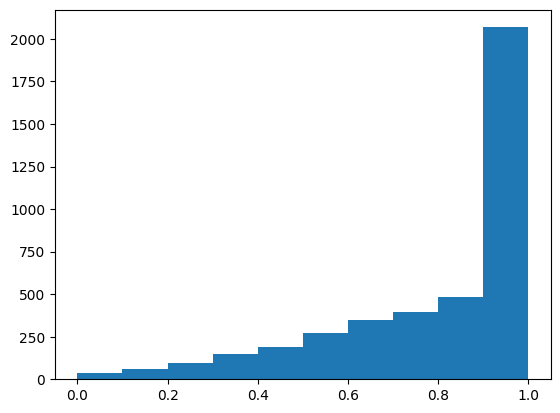

In [6]:
# Histogram of normalized pixels ranging from 0 - 1.

unnorm_img = cv2.imread(os.path.join(random_path,"9.png"))
unnorm_img = cv2.cvtColor(unnorm_img , cv2.COLOR_RGB2GRAY)

img = np.array(unnorm_img)
min_val = np.min(unnorm_img)
max_val = np.max(unnorm_img)

if max_val != min_val:
    img = (unnorm_img - min_val) / (max_val - min_val)
else:
    img = np.ones_like(unnorm_img)

pixels =[]
for i in range(64):
    for j in range(64):
        pixels.append(img[i][j])


plt.hist(pixels)
plt.show()

In [7]:
def read_imgs(class_name, path):
    labeled_imgs = []
    for filename in os.listdir(path):
        
        # Reading images from each folders
        img = cv2.imread(os.path.join(path,filename))
        
        #converting images from RGB to grayscle images with single channel.
        img = cv2.cvtColor(img , cv2.COLOR_RGB2GRAY)
    
        #Min - max normalizing images
        min_val = np.min(img)
        max_val = np.max(img)

        if max_val != min_val:
            img = (img - min_val) / (max_val - min_val)
        else:
            img = np.ones_like(img)
        
        #Label encoding = {donut:0, scratch:1, Random:2, Edge-loc:3, Edge-ring:4, center:5, Near-Full:6, Loc:7, None:8, Blacklist:9}
        if class_name == "donut":
            labeled_imgs.append((img, 0))
        elif class_name == "scratch":
            labeled_imgs.append((img, 1)) 
        elif class_name == "random":
            labeled_imgs.append((img, 2))
        elif class_name == "edgeloc":
            labeled_imgs.append((img, 3))
        elif class_name == "edgering":
            labeled_imgs.append((img, 4))
        elif class_name == "center":
            labeled_imgs.append((img, 5))
        elif class_name == "nearfull":
            labeled_imgs.append((img, 6))
        elif class_name == "loc":
            labeled_imgs.append((img, 7))
        elif class_name == "none":
            labeled_imgs.append((img, 8))
        elif class_name == "blacklist":
            labeled_imgs.append((img, 9))
        
    return labeled_imgs


In [8]:
# Storing the loaded data in class wise lists.

donut = read_imgs("donut", donut_path)
scratch = read_imgs("scratch", scratch_path)
random_ = read_imgs("random", random_path)
edgeloc = read_imgs("edgeloc", edgeloc_path)
edgering = read_imgs("edgering", edgering_path)
center = read_imgs("center", center_path)
nearfull = read_imgs("nearfull", nearfull_path)
loc = read_imgs("loc", loc_path)
none = read_imgs("none", none_path)

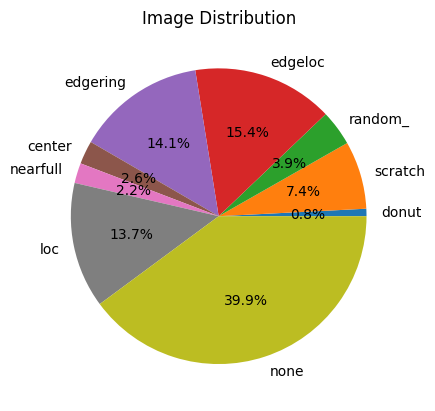

In [9]:
#Class distribution representation with Pie chart.
image_dict = {
    'donut': len(donut),
    'scratch': len(scratch),
    'random_': len(random_),
    'edgeloc': len(edgeloc),
    'edgering': len(edgering),
    'center': len(center),
    'nearfull':len(nearfull),
    'loc': len(loc),
    'none': len(none)
}

classes = list(image_dict.keys())
image_counts = list(image_dict.values())

# Create the pie chart
plt.pie(image_counts, labels=classes, autopct='%1.1f%%')

plt.title('Image Distribution')

plt.show()

In [12]:
# Function to Split 10% data of each class as a test dataset.

def split_data(images, test_size= 0.1):
    # Random seed for reproducibility
    random_seed = 42
    train_imgs, test_imgs = train_test_split(images, test_size=test_size, random_state=random_seed)
    return train_imgs, test_imgs

donut_train, donut_test = split_data(donut)
scratch_train, scratch_test = split_data(scratch)
random_train, random_test = split_data(random_)
edgeloc_train, edgeloc_test = split_data(edgeloc)
edgering_train, edgering_test = split_data(edgering)
center_train, center_test = split_data(center)
nearfull_train, nearfull_test = split_data(nearfull)
loc_train, loc_test = split_data(loc)
none_train, none_test = split_data(none)



In [13]:
print(len(donut_train) ,len(donut_test))
print(len(scratch_train), len(scratch_test))
print(len(random_train), len(random_test))
print(len(edgeloc_train), len(edgeloc_test))
print(len(edgering_train), len(edgering_test))
print(len(center_train), len(center_test))
print(len(nearfull_train), len(nearfull_test))
print(len(loc_train), len(loc_test))
print(len(none_train), len(none_test))

74 9
686 77
359 40
1423 159
1303 145
235 27
203 23
1269 142
3684 410


In [15]:
#Function to create image similar and dissimilar image pairs

def make_pair(data_req, pairing_size, _1, _2, _3, _4, _5, _6, _7, _8):
    positive_pair = []

    for i in range(len(data_req)):
        choice = np.random.choice(len(data_req), size= pairing_size, replace=False)
        for j in range(len(choice)):
            img_1 = data_req[i][0]
            img_2 = data_req[choice[j]][0]
            
            label1 = data_req[i][1]
            label2 = data_req[choice[j]][1]
            
            positive_pair.append((img_1, img_2, label1, label2, 1))

    print("length of positive pair: ", len(positive_pair))    

    #------------------non cat class----------------------
    non_data = list(itertools.chain(_1, _2, _3 ,_4, _5, _6, _7, _8))

    negative_pair =[]
     
    for i in range(len(data_req)):
        choice = np.random.choice(len(non_data), size= pairing_size, replace=False)
      
        for j in range(len(choice)):
            img_1 = data_req[i][0]
            img_2 = non_data[choice[j]][0]
            
            label1 = data_req[i][1]
            label2 = non_data[choice[j]][1]
            
            negative_pair.append((img_1, img_2,  label1, label2, 0))

    print("length of negative pair", len(negative_pair))


    final_data = list(itertools.chain(positive_pair, negative_pair))
   
    random.shuffle(final_data)
    print("=========length of train per class data========: ", len(final_data))
    
    return final_data

In [16]:
#creating image pairs

print("For donut class")
donut_pairs = make_pair(donut_train, 74, scratch, random_, edgeloc, edgering, center,nearfull, loc, none)
print("For scratch class")
scratch_pairs = make_pair(scratch_train, 8, donut, random_, edgeloc, edgering, center,nearfull, loc, none)
print("For random class")
random_pairs = make_pair(random_train, 15, scratch, donut, edgeloc, edgering, center,nearfull, loc, none)
print("For edgeloc class")
edgeloc_pairs = make_pair(edgeloc_train, 4, scratch, random_, donut, edgering, center,nearfull, loc, none)
print("For edgering class")
edgering_pairs = make_pair(edgering_train, 4, scratch, random_, edgeloc, donut, center,nearfull, loc, none)
print("For center class")
center_pairs = make_pair(center_train, 24, scratch, random_, edgeloc, edgering, donut,nearfull, loc, none)
print("For nearfull class")
nearfull_pairs = make_pair(nearfull_train, 28, scratch, random_, edgeloc, edgering, center,donut, loc, none)
print("For loc class")
loc_pairs = make_pair(loc_train, 4, scratch, random_, edgeloc, edgering, center,nearfull, donut, none)
print("For none class")
none_pairs = make_pair(none_train, 2, scratch, random_, edgeloc, edgering, center,nearfull, loc, donut)

For donut class
length of positive pair:  5476
length of negative pair 5476
=========length of train per class data========:  10952
For scratch class
length of positive pair:  5488
length of negative pair 5488
=========length of train per class data========:  10976
For random class
length of positive pair:  5385
length of negative pair 5385
=========length of train per class data========:  10770
For edgeloc class
length of positive pair:  5692
length of negative pair 5692
=========length of train per class data========:  11384
For edgering class
length of positive pair:  5212
length of negative pair 5212
=========length of train per class data========:  10424
For center class
length of positive pair:  5640
length of negative pair 5640
=========length of train per class data========:  11280
For nearfull class
length of positive pair:  5684
length of negative pair 5684
=========length of train per class data========:  11368
For loc class
length of positive pair:  5076
length of negative 

In [19]:
#Combining and shuffling the image pairs
combined_data = donut_pairs + scratch_pairs + random_pairs + edgeloc_pairs + edgering_pairs + \
                  center_pairs + nearfull_pairs + loc_pairs + none_pairs
                                 
print(len(combined_data))
random.shuffle(combined_data)

102042


In [20]:
#splitting data into training, validation 

train_, val_ = train_test_split(combined_data, test_size=0.1, random_state=42)

In [26]:
#Setting device to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [27]:
#Creating a custom dataset for pytorch framework to take care of image pairs

class SiameseNetworkDataset(Dataset):
    def __init__(self,image_pairs,transform=None):
        self.image_pairs = image_pairs    
        self.transform = transform
        self.pil_img = transforms.ToPILImage()
        
    def __getitem__(self,index):
        img1 =  self.image_pairs[index][0]
        img2 =  self.image_pairs[index][1]
        
        label1 = self.image_pairs[index][2]
        label2 = self.image_pairs[index][3]
        
        sim_label = self.image_pairs[index][4]
       
        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            
            label1 = torch.from_numpy(np.array([label1], dtype=np.float32))
            label2 = torch.from_numpy(np.array([label2], dtype=np.float32))
            
            sim_label = torch.from_numpy(np.array([sim_label], dtype=np.float32))
        
        return (img1, img2, label1, label2, sim_label)
    
    def __len__(self):
        return len(self.image_pairs)

In [28]:
# Adding data augumentation to images

transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((64,64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip()   
])

In [29]:
train_data = SiameseNetworkDataset(train_ , transform=transformation)
val_data = SiameseNetworkDataset(val_ , transform=transformation)

In [30]:
#Setting up the data loaders

train_loader = DataLoader(train_data, batch_size = 100, shuffle=True, num_workers= 6)
val_loader = DataLoader(val_data, batch_size= 100, shuffle=True, num_workers= 6)

In [31]:
#Siamese Neural Network Architecture

class BaseNetwork(nn.Module):
    
    def __init__(self):
        super(BaseNetwork, self).__init__()
        self.conv_layers = nn.Sequential(
                            nn.ReflectionPad2d(1),
                            nn.Conv2d(1, 10, kernel_size=10),
                            nn.ReLU(inplace=True),
                            nn.BatchNorm2d(10),
                            nn.Dropout2d(p=0.1),
            
                            nn.ReflectionPad2d(1),
                            nn.Conv2d(10, 10, kernel_size=5),
                            nn.ReLU(inplace=True),
                            nn.BatchNorm2d(10),
                            nn.Dropout2d(p=0.1),

                            nn.ReflectionPad2d(1),
                            nn.Conv2d(10, 10, kernel_size=3),
                            nn.ReLU(inplace=True),
                            nn.BatchNorm2d(10),
                            nn.Dropout2d(p=0.1)
                            )

        self.fully_connect = nn.Sequential(
                            nn.Linear(10*55*55, 800),
                            nn.ReLU(inplace=True),
                            nn.Dropout(p=0.1),
                            nn.Linear(800, 400),
                            nn.ReLU(inplace=True),
                            nn.Dropout(p=0.1),
                            nn.Linear(400, 100)
                            )

    def forward(self , x):
        output = self.conv_layers(x)
        output = output.view(output.size()[0], -1)
        output = self.fully_connect(output)
        
        return output
    
    
class SiameseNetwork(nn.Module):
    def __init__(self, base_network):
        super(SiameseNetwork, self).__init__()
        self.base_network = base_network
        self.sigmoid = nn.Sigmoid()
        
        self.fully_connect_2 = nn.Sequential(nn.Linear(100 , 50),
                                             nn.Tanh(),
                                             nn.Dropout(p=0.1),
                                             nn.Linear(50, 1)
                                            )

    def forward(self , inp1 , inp2):
        
        op1 = self.base_network(inp1)
        op2 = self.base_network(inp2)
        
        #taking absolute difference between the obtained embeddings
        output = torch.abs(op1 - op2)

        output = self.fully_connect_2(output)
        output = self.sigmoid(output)
        
        return output

In [32]:
# Initialize the base network and the siamese network
base_network = BaseNetwork().to(device)
network = SiameseNetwork(base_network).to(device)

#Adam optimizer
optimizer = optim.Adam(network.parameters(), lr = 0.00001 , weight_decay=0.00001)
scheduler =  optim.lr_scheduler.StepLR(optimizer, step_size= 50 , gamma=0.1)
criterion = nn.BCELoss()  #Binary Cross Entropy Loss
epochs = 200

In [33]:
#Training loop function

def train(net, num_epochs, training_data, validation_data, trainloader, valloader, name = None):    
    epoch_loss_train =[]
    epoch_loss_val =[]
    tolerance = 0
    for epoch in range(num_epochs):
        running_train =[]
        running_val =[]
        running_loss_train = 0
        running_loss_val = 0
        net.train()
        print("Mode: training   |   epoch: {}".format(epoch+1))
        for batch_idx, data in enumerate(tqdm(trainloader)):
            
            (img1,img2, _, _, label) = data
            img1 = img1.to(device).view(-1,1,64,64).float()
            img2 = img2.to(device).view(-1,1,64,64).float()
            label = label.float().to(device).view(-1,1)
            optimizer.zero_grad()
            
            output = net(img1, img2)
            loss = criterion(output, label)
            running_loss_train += loss.item()
            loss.backward()
            optimizer.step()
    
        print(scheduler.get_last_lr())
        train_loss_per_epoch = (running_loss_train)/len(train_data)
        epoch_loss_train.append(train_loss_per_epoch)
        print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch {} loss :{}".format(epoch+1, train_loss_per_epoch))
        
        net.eval()
        print("Mode: validation   |   epoch: {}".format(epoch+1))
        with torch.no_grad():
            for batch_idx, data in enumerate(tqdm(valloader)):
                (img1,img2, _, _, label) = data
                img1 = img1.to(device).view(-1,1,64,64).float()
                img2 = img2.to(device).view(-1,1,64,64).float()
                label = label.float().to(device).view(-1,1)
                
                output = net(img1, img2)
                loss = criterion(output, label)

                running_loss_val += loss.item()
   
        val_loss_per_epoch = (running_loss_val)/(len(val_data))
        epoch_loss_val.append(val_loss_per_epoch)
        print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch {} loss :{}".format(epoch+1, val_loss_per_epoch))          
        
        
        if (val_loss_per_epoch >= train_loss_per_epoch):
            tolerance += 1
        else:
            tolerance = 0
            
        if tolerance >= 2:
            #torch.save(net.state_dict(), os.path.join("./", str(name) + ".pt"))   
            print("Trained model is early stopped and saved at {} epoch".format(epoch+1))
            break
        
    return epoch_loss_train, epoch_loss_val, epoch +1

In [82]:
train_loss, val_loss, epochs = train(network, epochs, train_data, val_data, train_loader, val_loader, name = "Elmos_contra_donut" )

Mode: training   |   epoch: 1


100%|██████████| 919/919 [00:37<00:00, 24.22it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 1 loss :0.0058501249616870424
Mode: validation   |   epoch: 1


100%|██████████| 103/103 [00:01<00:00, 53.63it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 1 loss :0.005008209858496712
Mode: training   |   epoch: 2


100%|██████████| 919/919 [00:37<00:00, 24.26it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 2 loss :0.004820845186283947
Mode: validation   |   epoch: 2


100%|██████████| 103/103 [00:01<00:00, 54.56it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 2 loss :0.0044579951816303715
Mode: training   |   epoch: 3


100%|██████████| 919/919 [00:37<00:00, 24.26it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 3 loss :0.004389374628830998
Mode: validation   |   epoch: 3


100%|██████████| 103/103 [00:01<00:00, 53.71it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 3 loss :0.004108092264764628
Mode: training   |   epoch: 4


100%|██████████| 919/919 [00:37<00:00, 24.37it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 4 loss :0.004078176564629363
Mode: validation   |   epoch: 4


100%|██████████| 103/103 [00:01<00:00, 55.00it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 4 loss :0.0039644530711952
Mode: training   |   epoch: 5


100%|██████████| 919/919 [00:37<00:00, 24.55it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 5 loss :0.003833297146297762
Mode: validation   |   epoch: 5


100%|██████████| 103/103 [00:01<00:00, 55.05it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 5 loss :0.003682720291737188
Mode: training   |   epoch: 6


100%|██████████| 919/919 [00:37<00:00, 24.50it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 6 loss :0.00361111675863377
Mode: validation   |   epoch: 6


100%|██████████| 103/103 [00:01<00:00, 52.22it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 6 loss :0.0033830837532330352
Mode: training   |   epoch: 7


100%|██████████| 919/919 [00:37<00:00, 24.57it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 7 loss :0.0034232578660305826
Mode: validation   |   epoch: 7


100%|██████████| 103/103 [00:01<00:00, 54.37it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 7 loss :0.003224264497794339
Mode: training   |   epoch: 8


100%|██████████| 919/919 [00:37<00:00, 24.48it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 8 loss :0.0032237757769323313
Mode: validation   |   epoch: 8


100%|██████████| 103/103 [00:01<00:00, 54.17it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 8 loss :0.003120560890783696
Mode: training   |   epoch: 9


100%|██████████| 919/919 [00:37<00:00, 24.55it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 9 loss :0.003066874934334201
Mode: validation   |   epoch: 9


100%|██████████| 103/103 [00:01<00:00, 54.03it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 9 loss :0.0029011077226113596
Mode: training   |   epoch: 10


100%|██████████| 919/919 [00:37<00:00, 24.43it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 10 loss :0.002933974867349318
Mode: validation   |   epoch: 10


100%|██████████| 103/103 [00:01<00:00, 52.94it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 10 loss :0.0028619582807240915
Mode: training   |   epoch: 11


100%|██████████| 919/919 [00:37<00:00, 24.59it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 11 loss :0.0027799546296405687
Mode: validation   |   epoch: 11


100%|██████████| 103/103 [00:01<00:00, 54.43it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 11 loss :0.002611198527797772
Mode: training   |   epoch: 12


100%|██████████| 919/919 [00:37<00:00, 24.46it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 12 loss :0.002656802127792952
Mode: validation   |   epoch: 12


100%|██████████| 103/103 [00:01<00:00, 54.27it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 12 loss :0.0025441659848985574
Mode: training   |   epoch: 13


100%|██████████| 919/919 [00:37<00:00, 24.46it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 13 loss :0.0025243156897642276
Mode: validation   |   epoch: 13


100%|██████████| 103/103 [00:01<00:00, 51.82it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 13 loss :0.002363613155879909
Mode: training   |   epoch: 14


100%|██████████| 919/919 [00:37<00:00, 24.51it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 14 loss :0.002398993039375977
Mode: validation   |   epoch: 14


100%|██████████| 103/103 [00:01<00:00, 53.88it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 14 loss :0.002252683708592994
Mode: training   |   epoch: 15


100%|██████████| 919/919 [00:37<00:00, 24.72it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 15 loss :0.0022848995387101797
Mode: validation   |   epoch: 15


100%|██████████| 103/103 [00:01<00:00, 52.21it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 15 loss :0.002165544087077285
Mode: training   |   epoch: 16


100%|██████████| 919/919 [00:37<00:00, 24.56it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 16 loss :0.0021575993098318495
Mode: validation   |   epoch: 16


100%|██████████| 103/103 [00:01<00:00, 55.31it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 16 loss :0.002007491770531254
Mode: training   |   epoch: 17


100%|██████████| 919/919 [00:37<00:00, 24.49it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 17 loss :0.0020511654377034266
Mode: validation   |   epoch: 17


100%|██████████| 103/103 [00:01<00:00, 54.55it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 17 loss :0.0019469034198684356
Mode: training   |   epoch: 18


100%|██████████| 919/919 [00:37<00:00, 24.41it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 18 loss :0.0019236458578326724
Mode: validation   |   epoch: 18


100%|██████████| 103/103 [00:01<00:00, 53.15it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 18 loss :0.0018240282650615351
Mode: training   |   epoch: 19


100%|██████████| 919/919 [00:37<00:00, 24.44it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 19 loss :0.0018389106815947793
Mode: validation   |   epoch: 19


100%|██████████| 103/103 [00:01<00:00, 55.54it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 19 loss :0.0017284690187527583
Mode: training   |   epoch: 20


100%|██████████| 919/919 [00:37<00:00, 24.37it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 20 loss :0.0017359687542200636
Mode: validation   |   epoch: 20


100%|██████████| 103/103 [00:01<00:00, 53.18it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 20 loss :0.001533471167248175
Mode: training   |   epoch: 21


100%|██████████| 919/919 [00:37<00:00, 24.53it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 21 loss :0.0016198601140358807
Mode: validation   |   epoch: 21


100%|██████████| 103/103 [00:01<00:00, 52.95it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 21 loss :0.001500693379022046
Mode: training   |   epoch: 22


100%|██████████| 919/919 [00:37<00:00, 24.57it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 22 loss :0.0015495488550562862
Mode: validation   |   epoch: 22


100%|██████████| 103/103 [00:01<00:00, 53.48it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 22 loss :0.0014045452075749855
Mode: training   |   epoch: 23


100%|██████████| 919/919 [00:37<00:00, 24.41it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 23 loss :0.0014440653317948466
Mode: validation   |   epoch: 23


100%|██████████| 103/103 [00:01<00:00, 52.45it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 23 loss :0.0014109138674971988
Mode: training   |   epoch: 24


100%|██████████| 919/919 [00:37<00:00, 24.39it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 24 loss :0.001362769221851803
Mode: validation   |   epoch: 24


100%|██████████| 103/103 [00:01<00:00, 52.47it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 24 loss :0.0012225749999620586
Mode: training   |   epoch: 25


100%|██████████| 919/919 [00:37<00:00, 24.20it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 25 loss :0.0013192643882397237
Mode: validation   |   epoch: 25


100%|██████████| 103/103 [00:01<00:00, 53.29it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 25 loss :0.0011995705682145488
Mode: training   |   epoch: 26


100%|██████████| 919/919 [00:37<00:00, 24.44it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 26 loss :0.0012185829367329164
Mode: validation   |   epoch: 26


100%|██████████| 103/103 [00:01<00:00, 55.01it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 26 loss :0.0011143967638404593
Mode: training   |   epoch: 27


100%|██████████| 919/919 [00:37<00:00, 24.49it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 27 loss :0.0011612702349818697
Mode: validation   |   epoch: 27


100%|██████████| 103/103 [00:01<00:00, 53.31it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 27 loss :0.0010706105962621996
Mode: training   |   epoch: 28


100%|██████████| 919/919 [00:37<00:00, 24.42it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 28 loss :0.0011128443477282596
Mode: validation   |   epoch: 28


100%|██████████| 103/103 [00:01<00:00, 53.65it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 28 loss :0.0009721541469702237
Mode: training   |   epoch: 29


100%|██████████| 919/919 [00:37<00:00, 24.34it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 29 loss :0.0010515248952658294
Mode: validation   |   epoch: 29


100%|██████████| 103/103 [00:01<00:00, 53.72it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 29 loss :0.000965654066983302
Mode: training   |   epoch: 30


100%|██████████| 919/919 [00:37<00:00, 24.40it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 30 loss :0.0009892225110020524
Mode: validation   |   epoch: 30


100%|██████████| 103/103 [00:01<00:00, 52.27it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 30 loss :0.0009139092817960973
Mode: training   |   epoch: 31


100%|██████████| 919/919 [00:37<00:00, 24.29it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 31 loss :0.0009203672731177572
Mode: validation   |   epoch: 31


100%|██████████| 103/103 [00:01<00:00, 53.48it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 31 loss :0.0008261995279631271
Mode: training   |   epoch: 32


100%|██████████| 919/919 [00:37<00:00, 24.35it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 32 loss :0.000914898067633278
Mode: validation   |   epoch: 32


100%|██████████| 103/103 [00:01<00:00, 54.07it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 32 loss :0.0007955984929316421
Mode: training   |   epoch: 33


100%|██████████| 919/919 [00:37<00:00, 24.41it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 33 loss :0.0008663229295609077
Mode: validation   |   epoch: 33


100%|██████████| 103/103 [00:01<00:00, 53.78it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 33 loss :0.000776025020808989
Mode: training   |   epoch: 34


100%|██████████| 919/919 [00:37<00:00, 24.37it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 34 loss :0.0008252698536917041
Mode: validation   |   epoch: 34


100%|██████████| 103/103 [00:01<00:00, 54.38it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 34 loss :0.0007048523963403024
Mode: training   |   epoch: 35


100%|██████████| 919/919 [00:37<00:00, 24.50it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 35 loss :0.0007914503164603927
Mode: validation   |   epoch: 35


100%|██████████| 103/103 [00:01<00:00, 52.83it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 35 loss :0.0007080204903509966
Mode: training   |   epoch: 36


100%|██████████| 919/919 [00:37<00:00, 24.53it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 36 loss :0.0007417273474251285
Mode: validation   |   epoch: 36


100%|██████████| 103/103 [00:01<00:00, 53.45it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 36 loss :0.0007167115782892687
Mode: training   |   epoch: 37


100%|██████████| 919/919 [00:37<00:00, 24.56it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 37 loss :0.000732235451341756
Mode: validation   |   epoch: 37


100%|██████████| 103/103 [00:01<00:00, 52.24it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 37 loss :0.0006968957300369556
Mode: training   |   epoch: 38


100%|██████████| 919/919 [00:37<00:00, 24.44it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 38 loss :0.0006946218311021611
Mode: validation   |   epoch: 38


100%|██████████| 103/103 [00:01<00:00, 54.19it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 38 loss :0.0006061963389305026
Mode: training   |   epoch: 39


100%|██████████| 919/919 [00:37<00:00, 24.47it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 39 loss :0.0006616614446705489
Mode: validation   |   epoch: 39


100%|██████████| 103/103 [00:01<00:00, 51.67it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 39 loss :0.0005691214485138669
Mode: training   |   epoch: 40


100%|██████████| 919/919 [00:37<00:00, 24.35it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 40 loss :0.0006358333479246406
Mode: validation   |   epoch: 40


100%|██████████| 103/103 [00:01<00:00, 53.21it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 40 loss :0.0005399176804827949
Mode: training   |   epoch: 41


100%|██████████| 919/919 [00:37<00:00, 24.34it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 41 loss :0.0006064735514235527
Mode: validation   |   epoch: 41


100%|██████████| 103/103 [00:01<00:00, 52.43it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 41 loss :0.0005527487257381445
Mode: training   |   epoch: 42


100%|██████████| 919/919 [00:37<00:00, 24.47it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 42 loss :0.0005782142756680517
Mode: validation   |   epoch: 42


100%|██████████| 103/103 [00:01<00:00, 52.75it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 42 loss :0.0005279841011920319
Mode: training   |   epoch: 43


100%|██████████| 919/919 [00:37<00:00, 24.33it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 43 loss :0.0005637464667670277
Mode: validation   |   epoch: 43


100%|██████████| 103/103 [00:01<00:00, 51.80it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 43 loss :0.0005067227021341578
Mode: training   |   epoch: 44


100%|██████████| 919/919 [00:37<00:00, 24.40it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 44 loss :0.0005489398006746966
Mode: validation   |   epoch: 44


100%|██████████| 103/103 [00:01<00:00, 53.28it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 44 loss :0.0004641196665745128
Mode: training   |   epoch: 45


100%|██████████| 919/919 [00:37<00:00, 24.25it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 45 loss :0.0005381632831546729
Mode: validation   |   epoch: 45


100%|██████████| 103/103 [00:01<00:00, 52.32it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 45 loss :0.0004566698263470943
Mode: training   |   epoch: 46


100%|██████████| 919/919 [00:37<00:00, 24.40it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 46 loss :0.000510438500662403
Mode: validation   |   epoch: 46


100%|██████████| 103/103 [00:01<00:00, 52.94it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 46 loss :0.000433672738472791
Mode: training   |   epoch: 47


100%|██████████| 919/919 [00:37<00:00, 24.37it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 47 loss :0.00047480548858877525
Mode: validation   |   epoch: 47


100%|██████████| 103/103 [00:01<00:00, 54.88it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 47 loss :0.00039369525829331686
Mode: training   |   epoch: 48


100%|██████████| 919/919 [00:37<00:00, 24.34it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 48 loss :0.0004680043936218474
Mode: validation   |   epoch: 48


100%|██████████| 103/103 [00:01<00:00, 52.51it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 48 loss :0.0004003713805901981
Mode: training   |   epoch: 49


100%|██████████| 919/919 [00:37<00:00, 24.36it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 49 loss :0.00046333593047851644
Mode: validation   |   epoch: 49


100%|██████████| 103/103 [00:01<00:00, 55.52it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 49 loss :0.00036821716402541885
Mode: training   |   epoch: 50


100%|██████████| 919/919 [00:37<00:00, 24.47it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 50 loss :0.0004234773831592228
Mode: validation   |   epoch: 50


100%|██████████| 103/103 [00:01<00:00, 51.73it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 50 loss :0.00039440077345769
Mode: training   |   epoch: 51


100%|██████████| 919/919 [00:37<00:00, 24.47it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 51 loss :0.00041676095080631775
Mode: validation   |   epoch: 51


100%|██████████| 103/103 [00:01<00:00, 54.59it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 51 loss :0.0003533394303456193
Mode: training   |   epoch: 52


100%|██████████| 919/919 [00:37<00:00, 24.45it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 52 loss :0.0003932265072695263
Mode: validation   |   epoch: 52


100%|██████████| 103/103 [00:01<00:00, 53.01it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 52 loss :0.00034831120180388634
Mode: training   |   epoch: 53


100%|██████████| 919/919 [00:37<00:00, 24.33it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 53 loss :0.000387811442473644
Mode: validation   |   epoch: 53


100%|██████████| 103/103 [00:01<00:00, 55.63it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 53 loss :0.00032819612591679354
Mode: training   |   epoch: 54


100%|██████████| 919/919 [00:37<00:00, 24.34it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 54 loss :0.0003678815344539952
Mode: validation   |   epoch: 54


100%|██████████| 103/103 [00:01<00:00, 53.00it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 54 loss :0.000304673532241228
Mode: training   |   epoch: 55


100%|██████████| 919/919 [00:37<00:00, 24.34it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 55 loss :0.00035313996105519087
Mode: validation   |   epoch: 55


100%|██████████| 103/103 [00:01<00:00, 53.33it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 55 loss :0.0003081486152123618
Mode: training   |   epoch: 56


100%|██████████| 919/919 [00:37<00:00, 24.47it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 56 loss :0.0003507120914772504
Mode: validation   |   epoch: 56


100%|██████████| 103/103 [00:01<00:00, 53.00it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 56 loss :0.0003016185352650856
Mode: training   |   epoch: 57


100%|██████████| 919/919 [00:37<00:00, 24.38it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 57 loss :0.00034496939636277543
Mode: validation   |   epoch: 57


100%|██████████| 103/103 [00:01<00:00, 52.48it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 57 loss :0.0003516166579089639
Mode: training   |   epoch: 58


100%|██████████| 919/919 [00:37<00:00, 24.37it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 58 loss :0.00032940756242415975
Mode: validation   |   epoch: 58


100%|██████████| 103/103 [00:01<00:00, 55.05it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 58 loss :0.0002861657220845616
Mode: training   |   epoch: 59


100%|██████████| 919/919 [00:37<00:00, 24.35it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 59 loss :0.0003173813982596395
Mode: validation   |   epoch: 59


100%|██████████| 103/103 [00:01<00:00, 53.59it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 59 loss :0.0003141487533014883
Mode: training   |   epoch: 60


100%|██████████| 919/919 [00:37<00:00, 24.28it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 60 loss :0.0003046997138600186
Mode: validation   |   epoch: 60


100%|██████████| 103/103 [00:02<00:00, 51.30it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 60 loss :0.0002934151398002488
Mode: training   |   epoch: 61


100%|██████████| 919/919 [00:37<00:00, 24.38it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 61 loss :0.0003180048589545975
Mode: validation   |   epoch: 61


100%|██████████| 103/103 [00:01<00:00, 53.23it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 61 loss :0.00027973839211985397
Mode: training   |   epoch: 62


100%|██████████| 919/919 [00:37<00:00, 24.37it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 62 loss :0.0002826778800537317
Mode: validation   |   epoch: 62


100%|██████████| 103/103 [00:01<00:00, 52.68it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 62 loss :0.00026264182669062685
Mode: training   |   epoch: 63


100%|██████████| 919/919 [00:37<00:00, 24.41it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 63 loss :0.00028356682602258336
Mode: validation   |   epoch: 63


100%|██████████| 103/103 [00:01<00:00, 54.52it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 63 loss :0.00021880585077414466
Mode: training   |   epoch: 64


100%|██████████| 919/919 [00:37<00:00, 24.24it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 64 loss :0.0002669998648433926
Mode: validation   |   epoch: 64


100%|██████████| 103/103 [00:01<00:00, 53.27it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 64 loss :0.00022086083031806362
Mode: training   |   epoch: 65


100%|██████████| 919/919 [00:37<00:00, 24.39it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 65 loss :0.000265939880792094
Mode: validation   |   epoch: 65


100%|██████████| 103/103 [00:01<00:00, 53.33it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 65 loss :0.0002244113746547724
Mode: training   |   epoch: 66


100%|██████████| 919/919 [00:37<00:00, 24.25it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 66 loss :0.0002693593344422513
Mode: validation   |   epoch: 66


100%|██████████| 103/103 [00:01<00:00, 53.06it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 66 loss :0.00023117431070763272
Mode: training   |   epoch: 67


100%|██████████| 919/919 [00:37<00:00, 24.33it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 67 loss :0.0002519822135350221
Mode: validation   |   epoch: 67


100%|██████████| 103/103 [00:01<00:00, 53.52it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 67 loss :0.00019582890436612937
Mode: training   |   epoch: 68


100%|██████████| 919/919 [00:37<00:00, 24.32it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 68 loss :0.00023373088424137738
Mode: validation   |   epoch: 68


100%|██████████| 103/103 [00:01<00:00, 54.28it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 68 loss :0.0002150105040051346
Mode: training   |   epoch: 69


100%|██████████| 919/919 [00:37<00:00, 24.34it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 69 loss :0.0002454242147792731
Mode: validation   |   epoch: 69


100%|██████████| 103/103 [00:01<00:00, 51.88it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 69 loss :0.0002101277474506536
Mode: training   |   epoch: 70


100%|██████████| 919/919 [00:37<00:00, 24.41it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 70 loss :0.0002274387117082164
Mode: validation   |   epoch: 70


100%|██████████| 103/103 [00:01<00:00, 54.64it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 70 loss :0.00019668031285024335
Mode: training   |   epoch: 71


100%|██████████| 919/919 [00:37<00:00, 24.27it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 71 loss :0.0002213422272616348
Mode: validation   |   epoch: 71


100%|██████████| 103/103 [00:01<00:00, 52.96it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 71 loss :0.0001824595160990071
Mode: training   |   epoch: 72


100%|██████████| 919/919 [00:37<00:00, 24.40it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 72 loss :0.00023434708681554072
Mode: validation   |   epoch: 72


100%|██████████| 103/103 [00:01<00:00, 52.86it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 72 loss :0.00018293916970803524
Mode: training   |   epoch: 73


100%|██████████| 919/919 [00:37<00:00, 24.44it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 73 loss :0.0001987854524075793
Mode: validation   |   epoch: 73


100%|██████████| 103/103 [00:01<00:00, 52.05it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 73 loss :0.0001771597516353825
Mode: training   |   epoch: 74


100%|██████████| 919/919 [00:38<00:00, 24.17it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 74 loss :0.0002018442626054379
Mode: validation   |   epoch: 74


100%|██████████| 103/103 [00:01<00:00, 51.53it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 74 loss :0.00017783722250522656
Mode: training   |   epoch: 75


100%|██████████| 919/919 [00:37<00:00, 24.27it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 75 loss :0.00019566071473567427
Mode: validation   |   epoch: 75


100%|██████████| 103/103 [00:02<00:00, 51.21it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 75 loss :0.00017694186468073428
Mode: training   |   epoch: 76


100%|██████████| 919/919 [00:37<00:00, 24.47it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 76 loss :0.0002045910984386574
Mode: validation   |   epoch: 76


100%|██████████| 103/103 [00:01<00:00, 53.12it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 76 loss :0.00015993916579247952
Mode: training   |   epoch: 77


100%|██████████| 919/919 [00:37<00:00, 24.47it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 77 loss :0.0001916423401197686
Mode: validation   |   epoch: 77


100%|██████████| 103/103 [00:01<00:00, 53.97it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 77 loss :0.0001570930778510259
Mode: training   |   epoch: 78


100%|██████████| 919/919 [00:37<00:00, 24.53it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 78 loss :0.00019843243664975296
Mode: validation   |   epoch: 78


100%|██████████| 103/103 [00:01<00:00, 54.52it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 78 loss :0.0001940533421040348
Mode: training   |   epoch: 79


100%|██████████| 919/919 [00:37<00:00, 24.40it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 79 loss :0.00018629907624228358
Mode: validation   |   epoch: 79


100%|██████████| 103/103 [00:01<00:00, 53.14it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 79 loss :0.00015917854910237406
Mode: training   |   epoch: 80


100%|██████████| 919/919 [00:37<00:00, 24.28it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 80 loss :0.0001822209314380185
Mode: validation   |   epoch: 80


100%|██████████| 103/103 [00:01<00:00, 53.77it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 80 loss :0.00013863174302940608
Mode: training   |   epoch: 81


100%|██████████| 919/919 [00:37<00:00, 24.36it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 81 loss :0.00016584902761589704
Mode: validation   |   epoch: 81


100%|██████████| 103/103 [00:01<00:00, 54.99it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 81 loss :0.00015267532604934975
Mode: training   |   epoch: 82


100%|██████████| 919/919 [00:37<00:00, 24.42it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 82 loss :0.0001739911870940144
Mode: validation   |   epoch: 82


100%|██████████| 103/103 [00:01<00:00, 54.16it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 82 loss :0.00014279686081280612
Mode: training   |   epoch: 83


100%|██████████| 919/919 [00:37<00:00, 24.29it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 83 loss :0.00017392187097792965
Mode: validation   |   epoch: 83


100%|██████████| 103/103 [00:01<00:00, 55.01it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 83 loss :0.0001240740121388129
Mode: training   |   epoch: 84


100%|██████████| 919/919 [00:37<00:00, 24.48it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 84 loss :0.00017031493769013653
Mode: validation   |   epoch: 84


100%|██████████| 103/103 [00:01<00:00, 53.32it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 84 loss :0.00011692771254383878
Mode: training   |   epoch: 85


100%|██████████| 919/919 [00:37<00:00, 24.38it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 85 loss :0.0001695001661707148
Mode: validation   |   epoch: 85


100%|██████████| 103/103 [00:01<00:00, 52.38it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 85 loss :0.0001337625003566234
Mode: training   |   epoch: 86


100%|██████████| 919/919 [00:37<00:00, 24.25it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 86 loss :0.00016443359280361483
Mode: validation   |   epoch: 86


100%|██████████| 103/103 [00:01<00:00, 52.21it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 86 loss :0.0001289119761339528
Mode: training   |   epoch: 87


100%|██████████| 919/919 [00:37<00:00, 24.34it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 87 loss :0.00015754722735580894
Mode: validation   |   epoch: 87


100%|██████████| 103/103 [00:01<00:00, 52.77it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 87 loss :0.0001244760125098382
Mode: training   |   epoch: 88


100%|██████████| 919/919 [00:37<00:00, 24.31it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 88 loss :0.0001569843428225249
Mode: validation   |   epoch: 88


100%|██████████| 103/103 [00:01<00:00, 52.64it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 88 loss :0.00011427520322503905
Mode: training   |   epoch: 89


100%|██████████| 919/919 [00:37<00:00, 24.51it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 89 loss :0.0001534365571593356
Mode: validation   |   epoch: 89


100%|██████████| 103/103 [00:01<00:00, 52.47it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 89 loss :0.00013132595621956144
Mode: training   |   epoch: 90


100%|██████████| 919/919 [00:37<00:00, 24.46it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 90 loss :0.00014630325760522586
Mode: validation   |   epoch: 90


100%|██████████| 103/103 [00:01<00:00, 53.89it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 90 loss :0.0001064867740933907
Mode: training   |   epoch: 91


100%|██████████| 919/919 [00:37<00:00, 24.37it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 91 loss :0.0001369358021254991
Mode: validation   |   epoch: 91


100%|██████████| 103/103 [00:01<00:00, 52.87it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 91 loss :0.00011303306959112663
Mode: training   |   epoch: 92


100%|██████████| 919/919 [00:37<00:00, 24.31it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 92 loss :0.00014977957619649913
Mode: validation   |   epoch: 92


100%|██████████| 103/103 [00:01<00:00, 52.62it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 92 loss :0.00010161658924719569
Mode: training   |   epoch: 93


100%|██████████| 919/919 [00:37<00:00, 24.26it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 93 loss :0.0001335692934324765
Mode: validation   |   epoch: 93


100%|██████████| 103/103 [00:01<00:00, 54.63it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 93 loss :0.00010292557200384069
Mode: training   |   epoch: 94


100%|██████████| 919/919 [00:37<00:00, 24.30it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 94 loss :0.00013257900126014297
Mode: validation   |   epoch: 94


100%|██████████| 103/103 [00:01<00:00, 52.94it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 94 loss :0.00011016339788202877
Mode: training   |   epoch: 95


100%|██████████| 919/919 [00:37<00:00, 24.39it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 95 loss :0.0001334737043648215
Mode: validation   |   epoch: 95


100%|██████████| 103/103 [00:01<00:00, 52.63it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 95 loss :0.00010354320792399624
Mode: training   |   epoch: 96


100%|██████████| 919/919 [00:37<00:00, 24.48it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 96 loss :0.0001363922709901254
Mode: validation   |   epoch: 96


100%|██████████| 103/103 [00:01<00:00, 54.79it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 96 loss :0.00011199377022466248
Mode: training   |   epoch: 97


100%|██████████| 919/919 [00:37<00:00, 24.39it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 97 loss :0.00011978540103994102
Mode: validation   |   epoch: 97


100%|██████████| 103/103 [00:01<00:00, 53.90it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 97 loss :8.618242128093721e-05
Mode: training   |   epoch: 98


100%|██████████| 919/919 [00:37<00:00, 24.48it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 98 loss :0.00014283146764279702
Mode: validation   |   epoch: 98


100%|██████████| 103/103 [00:01<00:00, 54.33it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 98 loss :9.594023184567075e-05
Mode: training   |   epoch: 99


100%|██████████| 919/919 [00:37<00:00, 24.39it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 99 loss :0.00012553918007461167
Mode: validation   |   epoch: 99


100%|██████████| 103/103 [00:01<00:00, 54.53it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 99 loss :8.848920258293444e-05
Mode: training   |   epoch: 100


100%|██████████| 919/919 [00:37<00:00, 24.40it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 100 loss :0.0001122405968655945
Mode: validation   |   epoch: 100


100%|██████████| 103/103 [00:01<00:00, 52.96it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 100 loss :8.884614952604913e-05
Mode: training   |   epoch: 101


100%|██████████| 919/919 [00:37<00:00, 24.41it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 101 loss :0.00013492101356818234
Mode: validation   |   epoch: 101


100%|██████████| 103/103 [00:01<00:00, 53.11it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 101 loss :7.905106991130197e-05
Mode: training   |   epoch: 102


100%|██████████| 919/919 [00:37<00:00, 24.48it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 102 loss :0.0001303832019092569
Mode: validation   |   epoch: 102


100%|██████████| 103/103 [00:01<00:00, 53.84it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 102 loss :8.813165638298493e-05
Mode: training   |   epoch: 103


100%|██████████| 919/919 [00:37<00:00, 24.48it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 103 loss :0.00011084923367565966
Mode: validation   |   epoch: 103


100%|██████████| 103/103 [00:01<00:00, 53.63it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 103 loss :0.00010019088496391546
Mode: training   |   epoch: 104


100%|██████████| 919/919 [00:37<00:00, 24.40it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 104 loss :0.00012362488836029558
Mode: validation   |   epoch: 104


100%|██████████| 103/103 [00:01<00:00, 52.10it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 104 loss :7.911678541648817e-05
Mode: training   |   epoch: 105


100%|██████████| 919/919 [00:37<00:00, 24.33it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 105 loss :0.00011941974528512444
Mode: validation   |   epoch: 105


100%|██████████| 103/103 [00:01<00:00, 52.01it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 105 loss :8.615379930068436e-05
Mode: training   |   epoch: 106


100%|██████████| 919/919 [00:37<00:00, 24.37it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 106 loss :0.00012056773337961078
Mode: validation   |   epoch: 106


100%|██████████| 103/103 [00:01<00:00, 52.96it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 106 loss :7.940299978040775e-05
Mode: training   |   epoch: 107


100%|██████████| 919/919 [00:37<00:00, 24.39it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 107 loss :0.00010702332784664874
Mode: validation   |   epoch: 107


100%|██████████| 103/103 [00:02<00:00, 51.13it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 107 loss :8.681992608384219e-05
Mode: training   |   epoch: 108


100%|██████████| 919/919 [00:37<00:00, 24.44it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 108 loss :0.00010959949576498347
Mode: validation   |   epoch: 108


100%|██████████| 103/103 [00:01<00:00, 53.12it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 108 loss :9.147056115135033e-05
Mode: training   |   epoch: 109


100%|██████████| 919/919 [00:37<00:00, 24.39it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 109 loss :0.00011731946782416678
Mode: validation   |   epoch: 109


100%|██████████| 103/103 [00:01<00:00, 53.79it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 109 loss :7.495844565220112e-05
Mode: training   |   epoch: 110


100%|██████████| 919/919 [00:37<00:00, 24.43it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 110 loss :0.0001143702885238164
Mode: validation   |   epoch: 110


100%|██████████| 103/103 [00:02<00:00, 51.45it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 110 loss :8.691487185858826e-05
Mode: training   |   epoch: 111


100%|██████████| 919/919 [00:37<00:00, 24.38it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 111 loss :0.00011098551921473869
Mode: validation   |   epoch: 111


100%|██████████| 103/103 [00:01<00:00, 52.86it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 111 loss :7.379287337639726e-05
Mode: training   |   epoch: 112


100%|██████████| 919/919 [00:37<00:00, 24.36it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 112 loss :9.992394192576617e-05
Mode: validation   |   epoch: 112


100%|██████████| 103/103 [00:01<00:00, 54.58it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 112 loss :9.362851062779064e-05
Mode: training   |   epoch: 113


100%|██████████| 919/919 [00:37<00:00, 24.47it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 113 loss :0.00010617971793940996
Mode: validation   |   epoch: 113


100%|██████████| 103/103 [00:01<00:00, 52.92it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 113 loss :8.032986388597599e-05
Mode: training   |   epoch: 114


100%|██████████| 919/919 [00:37<00:00, 24.48it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 114 loss :0.00011540831815668675
Mode: validation   |   epoch: 114


100%|██████████| 103/103 [00:01<00:00, 52.74it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 114 loss :6.242232697423724e-05
Mode: training   |   epoch: 115


100%|██████████| 919/919 [00:37<00:00, 24.41it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 115 loss :9.932406029434752e-05
Mode: validation   |   epoch: 115


100%|██████████| 103/103 [00:01<00:00, 53.26it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 115 loss :6.951768693205248e-05
Mode: training   |   epoch: 116


100%|██████████| 919/919 [00:37<00:00, 24.48it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 116 loss :9.960971298020061e-05
Mode: validation   |   epoch: 116


100%|██████████| 103/103 [00:01<00:00, 52.93it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 116 loss :7.48588939654581e-05
Mode: training   |   epoch: 117


100%|██████████| 919/919 [00:37<00:00, 24.51it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 117 loss :0.00010409177713051213
Mode: validation   |   epoch: 117


100%|██████████| 103/103 [00:01<00:00, 53.24it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 117 loss :6.0289795045608116e-05
Mode: training   |   epoch: 118


100%|██████████| 919/919 [00:37<00:00, 24.45it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 118 loss :9.367115338068949e-05
Mode: validation   |   epoch: 118


100%|██████████| 103/103 [00:02<00:00, 50.71it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 118 loss :7.297878212310182e-05
Mode: training   |   epoch: 119


100%|██████████| 919/919 [00:37<00:00, 24.47it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 119 loss :9.52441209017611e-05
Mode: validation   |   epoch: 119


100%|██████████| 103/103 [00:01<00:00, 53.16it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 119 loss :8.936245593019669e-05
Mode: training   |   epoch: 120


100%|██████████| 919/919 [00:37<00:00, 24.54it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 120 loss :9.045719424562179e-05
Mode: validation   |   epoch: 120


100%|██████████| 103/103 [00:01<00:00, 53.80it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 120 loss :5.721726595764749e-05
Mode: training   |   epoch: 121


100%|██████████| 919/919 [00:37<00:00, 24.41it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 121 loss :0.00010132871944026065
Mode: validation   |   epoch: 121


100%|██████████| 103/103 [00:01<00:00, 52.15it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 121 loss :5.7090649549314994e-05
Mode: training   |   epoch: 122


100%|██████████| 919/919 [00:37<00:00, 24.43it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 122 loss :9.871554183511778e-05
Mode: validation   |   epoch: 122


100%|██████████| 103/103 [00:01<00:00, 53.47it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 122 loss :5.974836105018551e-05
Mode: training   |   epoch: 123


100%|██████████| 919/919 [00:37<00:00, 24.29it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 123 loss :9.736510939535928e-05
Mode: validation   |   epoch: 123


100%|██████████| 103/103 [00:01<00:00, 53.00it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 123 loss :5.31825730564848e-05
Mode: training   |   epoch: 124


100%|██████████| 919/919 [00:37<00:00, 24.35it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 124 loss :8.733700530717047e-05
Mode: validation   |   epoch: 124


100%|██████████| 103/103 [00:01<00:00, 52.54it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 124 loss :6.213326199903207e-05
Mode: training   |   epoch: 125


100%|██████████| 919/919 [00:37<00:00, 24.43it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 125 loss :9.28587993601999e-05
Mode: validation   |   epoch: 125


100%|██████████| 103/103 [00:01<00:00, 52.10it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 125 loss :5.2519942513912995e-05
Mode: training   |   epoch: 126


100%|██████████| 919/919 [00:37<00:00, 24.46it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 126 loss :8.32190145139734e-05
Mode: validation   |   epoch: 126


100%|██████████| 103/103 [00:01<00:00, 55.72it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 126 loss :5.683148632454378e-05
Mode: training   |   epoch: 127


100%|██████████| 919/919 [00:37<00:00, 24.23it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 127 loss :9.257071788875546e-05
Mode: validation   |   epoch: 127


100%|██████████| 103/103 [00:01<00:00, 52.16it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 127 loss :6.709181767966395e-05
Mode: training   |   epoch: 128


100%|██████████| 919/919 [00:37<00:00, 24.48it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 128 loss :9.17120948521634e-05
Mode: validation   |   epoch: 128


100%|██████████| 103/103 [00:01<00:00, 53.86it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 128 loss :6.845125817638557e-05
Mode: training   |   epoch: 129


100%|██████████| 919/919 [00:37<00:00, 24.45it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 129 loss :8.271869805057972e-05
Mode: validation   |   epoch: 129


100%|██████████| 103/103 [00:02<00:00, 51.01it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 129 loss :7.155419938114099e-05
Mode: training   |   epoch: 130


100%|██████████| 919/919 [00:37<00:00, 24.49it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 130 loss :9.285551551549741e-05
Mode: validation   |   epoch: 130


100%|██████████| 103/103 [00:01<00:00, 54.09it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 130 loss :6.909789423123349e-05
Mode: training   |   epoch: 131


100%|██████████| 919/919 [00:37<00:00, 24.42it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 131 loss :8.125405299858681e-05
Mode: validation   |   epoch: 131


100%|██████████| 103/103 [00:01<00:00, 53.53it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 131 loss :6.091972389079629e-05
Mode: training   |   epoch: 132


100%|██████████| 919/919 [00:37<00:00, 24.70it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 132 loss :8.655601295706117e-05
Mode: validation   |   epoch: 132


100%|██████████| 103/103 [00:01<00:00, 52.96it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 132 loss :6.125325463164191e-05
Mode: training   |   epoch: 133


100%|██████████| 919/919 [00:37<00:00, 24.38it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 133 loss :8.761499291622643e-05
Mode: validation   |   epoch: 133


100%|██████████| 103/103 [00:01<00:00, 54.00it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 133 loss :6.062995656572711e-05
Mode: training   |   epoch: 134


100%|██████████| 919/919 [00:37<00:00, 24.20it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 134 loss :8.489481830143749e-05
Mode: validation   |   epoch: 134


100%|██████████| 103/103 [00:01<00:00, 53.69it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 134 loss :6.02606112858516e-05
Mode: training   |   epoch: 135


100%|██████████| 919/919 [00:37<00:00, 24.20it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 135 loss :8.32699917731955e-05
Mode: validation   |   epoch: 135


100%|██████████| 103/103 [00:01<00:00, 54.70it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 135 loss :5.67504696152481e-05
Mode: training   |   epoch: 136


100%|██████████| 919/919 [00:37<00:00, 24.31it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 136 loss :7.971684274944589e-05
Mode: validation   |   epoch: 136


100%|██████████| 103/103 [00:01<00:00, 51.53it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 136 loss :4.971288975619759e-05
Mode: training   |   epoch: 137


100%|██████████| 919/919 [00:37<00:00, 24.35it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 137 loss :7.976650471340838e-05
Mode: validation   |   epoch: 137


100%|██████████| 103/103 [00:01<00:00, 54.25it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 137 loss :5.664250605576751e-05
Mode: training   |   epoch: 138


100%|██████████| 919/919 [00:37<00:00, 24.58it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 138 loss :7.439423781166995e-05
Mode: validation   |   epoch: 138


100%|██████████| 103/103 [00:01<00:00, 52.37it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 138 loss :5.3734216663510976e-05
Mode: training   |   epoch: 139


100%|██████████| 919/919 [00:37<00:00, 24.44it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 139 loss :7.900402606569274e-05
Mode: validation   |   epoch: 139


100%|██████████| 103/103 [00:01<00:00, 51.54it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 139 loss :7.244051618590296e-05
Mode: training   |   epoch: 140


100%|██████████| 919/919 [00:37<00:00, 24.47it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 140 loss :7.373800296054517e-05
Mode: validation   |   epoch: 140


100%|██████████| 103/103 [00:01<00:00, 53.24it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 140 loss :5.970281589338109e-05
Mode: training   |   epoch: 141


100%|██████████| 919/919 [00:37<00:00, 24.36it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 141 loss :8.277414037984439e-05
Mode: validation   |   epoch: 141


100%|██████████| 103/103 [00:01<00:00, 54.10it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 141 loss :7.068539189851474e-05
Mode: training   |   epoch: 142


100%|██████████| 919/919 [00:37<00:00, 24.57it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 142 loss :7.78254415117601e-05
Mode: validation   |   epoch: 142


100%|██████████| 103/103 [00:01<00:00, 52.07it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 142 loss :5.3274626262338936e-05
Mode: training   |   epoch: 143


100%|██████████| 919/919 [00:37<00:00, 24.39it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 143 loss :7.67594974217016e-05
Mode: validation   |   epoch: 143


100%|██████████| 103/103 [00:01<00:00, 53.54it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 143 loss :5.382660962307565e-05
Mode: training   |   epoch: 144


100%|██████████| 919/919 [00:37<00:00, 24.27it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 144 loss :8.509129579253791e-05
Mode: validation   |   epoch: 144


100%|██████████| 103/103 [00:01<00:00, 53.01it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 144 loss :4.9990986597653015e-05
Mode: training   |   epoch: 145


100%|██████████| 919/919 [00:37<00:00, 24.41it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 145 loss :7.687945201445583e-05
Mode: validation   |   epoch: 145


100%|██████████| 103/103 [00:01<00:00, 53.93it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 145 loss :5.5851472296243054e-05
Mode: training   |   epoch: 146


100%|██████████| 919/919 [00:37<00:00, 24.51it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 146 loss :6.546343632554097e-05
Mode: validation   |   epoch: 146


100%|██████████| 103/103 [00:02<00:00, 50.68it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 146 loss :5.714527526021639e-05
Mode: training   |   epoch: 147


100%|██████████| 919/919 [00:37<00:00, 24.47it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 147 loss :7.035258372394107e-05
Mode: validation   |   epoch: 147


100%|██████████| 103/103 [00:01<00:00, 54.83it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 147 loss :7.450005887533707e-05
Mode: training   |   epoch: 148


100%|██████████| 919/919 [00:37<00:00, 24.29it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 148 loss :7.293528772119154e-05
Mode: validation   |   epoch: 148


100%|██████████| 103/103 [00:01<00:00, 53.72it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 148 loss :5.7096729095658356e-05
Mode: training   |   epoch: 149


100%|██████████| 919/919 [00:37<00:00, 24.47it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 149 loss :7.380871278699624e-05
Mode: validation   |   epoch: 149


100%|██████████| 103/103 [00:01<00:00, 54.81it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 149 loss :5.68401512048934e-05
Mode: training   |   epoch: 150


100%|██████████| 919/919 [00:37<00:00, 24.37it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 150 loss :7.194316254921333e-05
Mode: validation   |   epoch: 150


100%|██████████| 103/103 [00:01<00:00, 53.06it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 150 loss :5.8583571419125767e-05
Mode: training   |   epoch: 151


100%|██████████| 919/919 [00:37<00:00, 24.44it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 151 loss :7.314237966213113e-05
Mode: validation   |   epoch: 151


100%|██████████| 103/103 [00:01<00:00, 54.32it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 151 loss :4.835749082916381e-05
Mode: training   |   epoch: 152


100%|██████████| 919/919 [00:37<00:00, 24.42it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 152 loss :6.693872964718265e-05
Mode: validation   |   epoch: 152


100%|██████████| 103/103 [00:01<00:00, 54.19it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 152 loss :5.113388121796059e-05
Mode: training   |   epoch: 153


100%|██████████| 919/919 [00:37<00:00, 24.39it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 153 loss :6.185662844777491e-05
Mode: validation   |   epoch: 153


100%|██████████| 103/103 [00:01<00:00, 54.37it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 153 loss :5.2108955005259704e-05
Mode: training   |   epoch: 154


100%|██████████| 919/919 [00:37<00:00, 24.53it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 154 loss :7.11040001971756e-05
Mode: validation   |   epoch: 154


100%|██████████| 103/103 [00:01<00:00, 53.04it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 154 loss :5.517565858144713e-05
Mode: training   |   epoch: 155


100%|██████████| 919/919 [00:37<00:00, 24.41it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 155 loss :6.345761026313496e-05
Mode: validation   |   epoch: 155


100%|██████████| 103/103 [00:01<00:00, 54.43it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 155 loss :6.3982935657299e-05
Mode: training   |   epoch: 156


100%|██████████| 919/919 [00:37<00:00, 24.36it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 156 loss :6.496543971832562e-05
Mode: validation   |   epoch: 156


100%|██████████| 103/103 [00:01<00:00, 53.11it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 156 loss :4.754571413467531e-05
Mode: training   |   epoch: 157


100%|██████████| 919/919 [00:37<00:00, 24.42it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 157 loss :7.32436705787297e-05
Mode: validation   |   epoch: 157


100%|██████████| 103/103 [00:01<00:00, 54.64it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 157 loss :5.6566152190787296e-05
Mode: training   |   epoch: 158


100%|██████████| 919/919 [00:37<00:00, 24.37it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 158 loss :5.9497993545851585e-05
Mode: validation   |   epoch: 158


100%|██████████| 103/103 [00:01<00:00, 52.71it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 158 loss :5.3290138872409225e-05
Mode: training   |   epoch: 159


100%|██████████| 919/919 [00:37<00:00, 24.30it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 159 loss :6.734011682814585e-05
Mode: validation   |   epoch: 159


100%|██████████| 103/103 [00:01<00:00, 53.44it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 159 loss :6.746691868031655e-05
Mode: training   |   epoch: 160


100%|██████████| 919/919 [00:37<00:00, 24.24it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 160 loss :6.967307336154409e-05
Mode: validation   |   epoch: 160


100%|██████████| 103/103 [00:01<00:00, 53.20it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 160 loss :6.199973780367047e-05
Mode: training   |   epoch: 161


100%|██████████| 919/919 [00:37<00:00, 24.36it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 161 loss :5.802429604349759e-05
Mode: validation   |   epoch: 161


100%|██████████| 103/103 [00:01<00:00, 53.76it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 161 loss :4.553606765963491e-05
Mode: training   |   epoch: 162


100%|██████████| 919/919 [00:37<00:00, 24.37it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 162 loss :6.23091656148856e-05
Mode: validation   |   epoch: 162


100%|██████████| 103/103 [00:01<00:00, 52.40it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 162 loss :5.0112534877819056e-05
Mode: training   |   epoch: 163


100%|██████████| 919/919 [00:37<00:00, 24.45it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 163 loss :5.775063140729866e-05
Mode: validation   |   epoch: 163


100%|██████████| 103/103 [00:01<00:00, 53.97it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 163 loss :4.5153004163120775e-05
Mode: training   |   epoch: 164


100%|██████████| 919/919 [00:37<00:00, 24.34it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 164 loss :6.295971490492187e-05
Mode: validation   |   epoch: 164


100%|██████████| 103/103 [00:02<00:00, 51.08it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 164 loss :3.7675849223073205e-05
Mode: training   |   epoch: 165


100%|██████████| 919/919 [00:37<00:00, 24.38it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 165 loss :5.9610708124002e-05
Mode: validation   |   epoch: 165


100%|██████████| 103/103 [00:01<00:00, 53.54it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 165 loss :5.036783362439907e-05
Mode: training   |   epoch: 166


100%|██████████| 919/919 [00:37<00:00, 24.22it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 166 loss :6.054079750726738e-05
Mode: validation   |   epoch: 166


100%|██████████| 103/103 [00:01<00:00, 53.30it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 166 loss :5.017266321614967e-05
Mode: training   |   epoch: 167


100%|██████████| 919/919 [00:37<00:00, 24.32it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 167 loss :6.190376721806667e-05
Mode: validation   |   epoch: 167


100%|██████████| 103/103 [00:01<00:00, 52.37it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 167 loss :3.944705137474182e-05
Mode: training   |   epoch: 168


100%|██████████| 919/919 [00:37<00:00, 24.45it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 168 loss :6.768474170449536e-05
Mode: validation   |   epoch: 168


100%|██████████| 103/103 [00:01<00:00, 53.67it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 168 loss :4.548132635119938e-05
Mode: training   |   epoch: 169


100%|██████████| 919/919 [00:37<00:00, 24.32it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 169 loss :5.885476069716917e-05
Mode: validation   |   epoch: 169


100%|██████████| 103/103 [00:01<00:00, 53.55it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 169 loss :4.3746737454936185e-05
Mode: training   |   epoch: 170


100%|██████████| 919/919 [00:37<00:00, 24.35it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 170 loss :5.6486181793166506e-05
Mode: validation   |   epoch: 170


100%|██████████| 103/103 [00:01<00:00, 52.28it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 170 loss :4.896073051783807e-05
Mode: training   |   epoch: 171


100%|██████████| 919/919 [00:37<00:00, 24.51it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 171 loss :5.0841350394170333e-05
Mode: validation   |   epoch: 171


100%|██████████| 103/103 [00:01<00:00, 53.33it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 171 loss :4.492671928335541e-05
Mode: training   |   epoch: 172


100%|██████████| 919/919 [00:37<00:00, 24.43it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 172 loss :6.20302440278874e-05
Mode: validation   |   epoch: 172


100%|██████████| 103/103 [00:01<00:00, 51.97it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 172 loss :5.214961086960997e-05
Mode: training   |   epoch: 173


100%|██████████| 919/919 [00:37<00:00, 24.29it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 173 loss :5.699908791287956e-05
Mode: validation   |   epoch: 173


100%|██████████| 103/103 [00:01<00:00, 54.44it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 173 loss :5.022481564475275e-05
Mode: training   |   epoch: 174


100%|██████████| 919/919 [00:37<00:00, 24.33it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 174 loss :5.470939930007508e-05
Mode: validation   |   epoch: 174


100%|██████████| 103/103 [00:01<00:00, 52.66it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 174 loss :4.26816954418911e-05
Mode: training   |   epoch: 175


100%|██████████| 919/919 [00:37<00:00, 24.32it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 175 loss :5.2845928805610304e-05
Mode: validation   |   epoch: 175


100%|██████████| 103/103 [00:01<00:00, 54.02it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 175 loss :3.7482051578766064e-05
Mode: training   |   epoch: 176


100%|██████████| 919/919 [00:37<00:00, 24.42it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 176 loss :5.579197670067908e-05
Mode: validation   |   epoch: 176


100%|██████████| 103/103 [00:01<00:00, 52.85it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 176 loss :5.123663439503463e-05
Mode: training   |   epoch: 177


100%|██████████| 919/919 [00:37<00:00, 24.42it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 177 loss :5.950123511391042e-05
Mode: validation   |   epoch: 177


100%|██████████| 103/103 [00:01<00:00, 53.57it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 177 loss :3.696964041645685e-05
Mode: training   |   epoch: 178


100%|██████████| 919/919 [00:37<00:00, 24.38it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 178 loss :5.532633508219327e-05
Mode: validation   |   epoch: 178


100%|██████████| 103/103 [00:01<00:00, 53.58it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 178 loss :3.6358751477002594e-05
Mode: training   |   epoch: 179


100%|██████████| 919/919 [00:37<00:00, 24.54it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 179 loss :5.583054908733078e-05
Mode: validation   |   epoch: 179


100%|██████████| 103/103 [00:01<00:00, 53.33it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 179 loss :3.92346258465662e-05
Mode: training   |   epoch: 180


100%|██████████| 919/919 [00:37<00:00, 24.56it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 180 loss :5.198495975517929e-05
Mode: validation   |   epoch: 180


100%|██████████| 103/103 [00:01<00:00, 53.21it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 180 loss :4.066887558841716e-05
Mode: training   |   epoch: 181


100%|██████████| 919/919 [00:37<00:00, 24.30it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 181 loss :5.125763010812562e-05
Mode: validation   |   epoch: 181


100%|██████████| 103/103 [00:01<00:00, 52.92it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 181 loss :4.6226601841865076e-05
Mode: training   |   epoch: 182


100%|██████████| 919/919 [00:37<00:00, 24.36it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 182 loss :5.647627886189792e-05
Mode: validation   |   epoch: 182


100%|██████████| 103/103 [00:01<00:00, 52.28it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 182 loss :4.314290713425315e-05
Mode: training   |   epoch: 183


100%|██████████| 919/919 [00:37<00:00, 24.43it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 183 loss :4.753963456698111e-05
Mode: validation   |   epoch: 183


100%|██████████| 103/103 [00:01<00:00, 53.65it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 183 loss :3.6760646783877284e-05
Mode: training   |   epoch: 184


100%|██████████| 919/919 [00:37<00:00, 24.42it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 184 loss :5.1480431423634015e-05
Mode: validation   |   epoch: 184


100%|██████████| 103/103 [00:01<00:00, 54.35it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 184 loss :4.1656960924284915e-05
Mode: training   |   epoch: 185


100%|██████████| 919/919 [00:37<00:00, 24.44it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 185 loss :5.714609547765941e-05
Mode: validation   |   epoch: 185


100%|██████████| 103/103 [00:01<00:00, 54.63it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 185 loss :4.362209488717228e-05
Mode: training   |   epoch: 186


100%|██████████| 919/919 [00:37<00:00, 24.55it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 186 loss :5.561451390364826e-05
Mode: validation   |   epoch: 186


100%|██████████| 103/103 [00:01<00:00, 54.08it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 186 loss :5.161186654829899e-05
Mode: training   |   epoch: 187


100%|██████████| 919/919 [00:37<00:00, 24.37it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 187 loss :5.12699591803928e-05
Mode: validation   |   epoch: 187


100%|██████████| 103/103 [00:01<00:00, 53.74it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 187 loss :4.625864966248899e-05
Mode: training   |   epoch: 188


100%|██████████| 919/919 [00:37<00:00, 24.43it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 188 loss :4.656555230002966e-05
Mode: validation   |   epoch: 188


100%|██████████| 103/103 [00:01<00:00, 53.40it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 188 loss :5.339985230183496e-05
Mode: training   |   epoch: 189


100%|██████████| 919/919 [00:37<00:00, 24.44it/s]


[1e-05]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 189 loss :4.9220170996626756e-05
Mode: validation   |   epoch: 189


100%|██████████| 103/103 [00:01<00:00, 53.24it/s]

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 189 loss :5.6121373817298175e-05
Trained model is early stopped and saved at 189 epoch


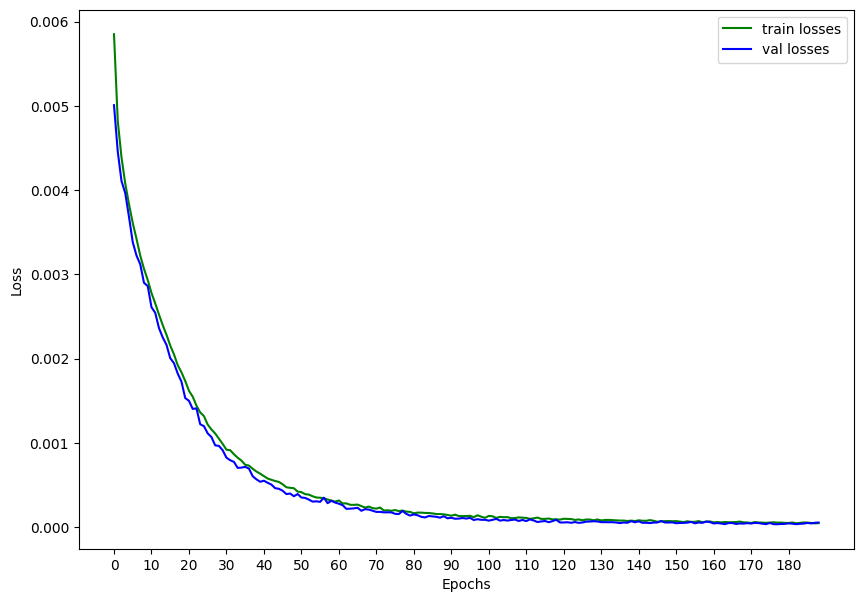

In [117]:
#Plotting the loss graph

plt.figure(figsize=(10, 7))

plt.plot(train_loss, color='green', label='train losses')
plt.plot(val_loss, color='blue', label='val losses')

plt.xticks(range(0, epochs + 1, 10))

plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.savefig('./Siamese_BCE_loss_200_epoch_graph.png')
plt.show()


In [172]:
#torch.save(base_network.state_dict(), "./siamese_BCE_base.pt")
#torch.save(network.state_dict(), "./siamese_BCE_main.pt")

In [34]:
load_base_net = BaseNetwork().to(device)
load_siamese_net = SiameseNetwork(load_base_net).to(device)

In [42]:
#loading the saved weights

load_base_net.load_state_dict(torch.load("./siamese_BCE_base.pt", map_location=device))
load_siamese_net.load_state_dict(torch.load("./siamese_BCE_main.pt", map_location=device))

<All keys matched successfully>

In [43]:
#setting models to evaluation mode
load_base_net.eval()
load_siamese_net.eval()

SiameseNetwork(
  (base_network): BaseNetwork(
    (conv_layers): Sequential(
      (0): ReflectionPad2d((1, 1, 1, 1))
      (1): Conv2d(1, 10, kernel_size=(10, 10), stride=(1, 1))
      (2): ReLU(inplace=True)
      (3): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): Dropout2d(p=0.1, inplace=False)
      (5): ReflectionPad2d((1, 1, 1, 1))
      (6): Conv2d(10, 10, kernel_size=(5, 5), stride=(1, 1))
      (7): ReLU(inplace=True)
      (8): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): Dropout2d(p=0.1, inplace=False)
      (10): ReflectionPad2d((1, 1, 1, 1))
      (11): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
      (12): ReLU(inplace=True)
      (13): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (14): Dropout2d(p=0.1, inplace=False)
    )
    (fully_connect): Sequential(
      (0): Linear(in_features=30250, out_features=800, bias=True)
      (1): Re

In [44]:
from torchsummary import summary
summary(load_base_net.to(device), input_size = (1,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ReflectionPad2d-1            [-1, 1, 66, 66]               0
            Conv2d-2           [-1, 10, 57, 57]           1,010
              ReLU-3           [-1, 10, 57, 57]               0
       BatchNorm2d-4           [-1, 10, 57, 57]              20
         Dropout2d-5           [-1, 10, 57, 57]               0
   ReflectionPad2d-6           [-1, 10, 59, 59]               0
            Conv2d-7           [-1, 10, 55, 55]           2,510
              ReLU-8           [-1, 10, 55, 55]               0
       BatchNorm2d-9           [-1, 10, 55, 55]              20
        Dropout2d-10           [-1, 10, 55, 55]               0
  ReflectionPad2d-11           [-1, 10, 57, 57]               0
           Conv2d-12           [-1, 10, 55, 55]             910
             ReLU-13           [-1, 10, 55, 55]               0
      BatchNorm2d-14           [-1, 10,

In [46]:
class_names = {0:'donut', 1:'scratch', 2:'random', 3:'edgeloc', 4:'edgering', 5:'center', 6:'nearfull', 7:'loc', 8:'none'}

complete_data = donut + scratch + random_ + edgeloc + edgering + center + nearfull + loc + none
random.shuffle(complete_data)

In [47]:
#converting raw images into 1D numpy array

dataset_images =[]
dataset_labels =[]
for (img, labl) in complete_data:
    dataset_images.append(img)
    dataset_labels.append(labl)
      
dataset_images = np.array(dataset_images)
dataset_labels = np.array(dataset_labels)
reshaped_img = dataset_images.reshape(dataset_images.shape[0], -1)
reshaped_labels = dataset_labels.reshape(dataset_images.shape[0], -1)    

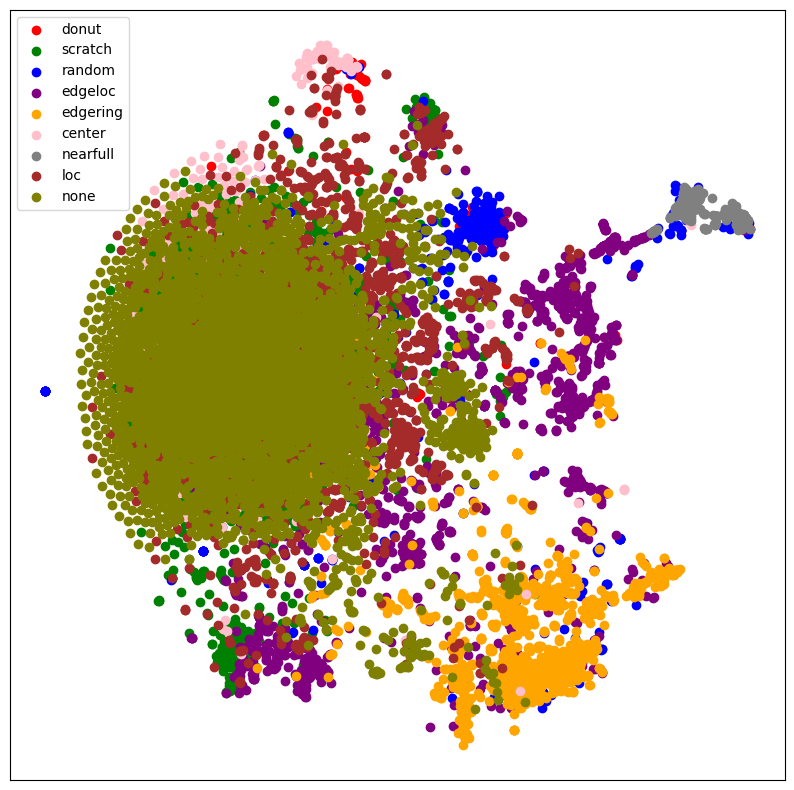

In [40]:
# Plotting 1D raw images in a 2D plot

tsne = TSNE(n_components=2, random_state=42)
imgs_2D = tsne.fit_transform(reshaped_img)

# Plot the results
plt.figure(figsize=(10, 10))
colors = ['red', 'green', 'blue', 'purple', 'orange', 'pink', 'gray', 'brown', 'olive'] # list of colors for different classes
for i in range(len(colors)):
    plt.scatter(imgs_2D[dataset_labels ==i, 0], imgs_2D[dataset_labels==i, 1], c=colors[i], label=str(class_names[i]))
plt.legend()

# Remove x and y tick labels
plt.xticks([])
plt.yticks([])

plt.savefig('./_gray_tsne_raw_img_2D_plot.png')

plt.show()

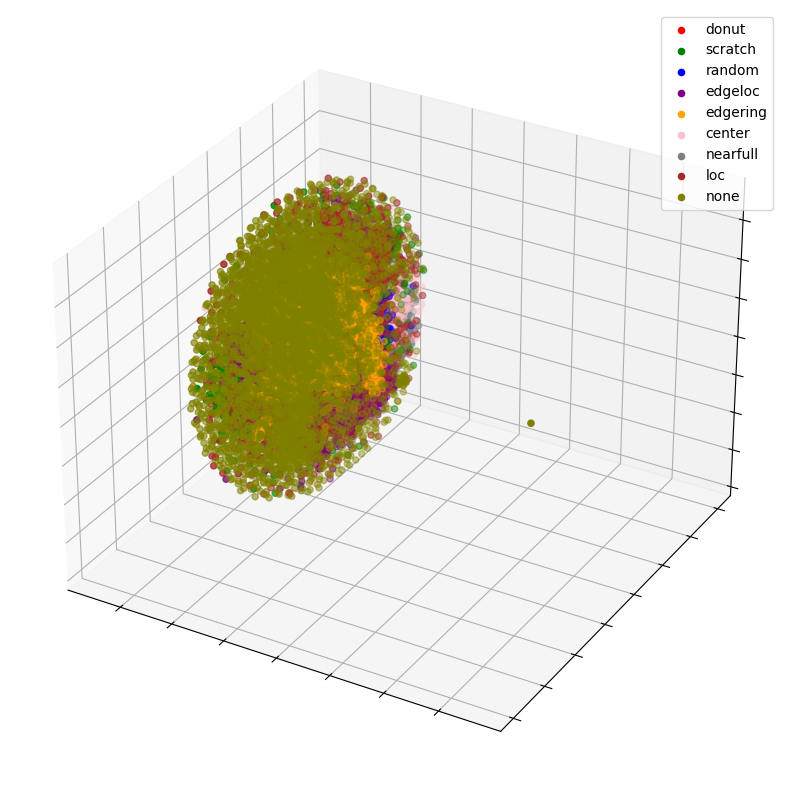

In [92]:
# Plotting 1D raw images in a 3D plot

tsne = TSNE(n_components=3, random_state=42)
imgs_2D = tsne.fit_transform(reshaped_img)

# Plot the results in 3D
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
colors = ['red', 'green', 'blue', 'purple', 'orange', 'pink', 'gray', 'brown', 'olive'] # list of colors for different classes
for i in range(len(colors)):
    ax.scatter(imgs_2D[dataset_labels==i, 0], imgs_2D[dataset_labels==i, 1], imgs_2D[dataset_labels==i, 2], c=colors[i], label=str(class_names[i]))
ax.legend()

# Remove x, y, and z tick labels, but keep the grid
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

# Save the plot as an image file
plt.savefig('./_gray_tsne_raw_img_3D_plot.png')

plt.show()

In [ ]:
#Generating feature embeddings using the subnetwork of a trained siamese.

embeddings = []
labels = []
with torch.no_grad():
    for (img, label) in complete_data:
       
        img = torch.from_numpy(img)
        img = img.float().to(device)
        img = img.view(1,1,64,64)
        label = torch.from_numpy(np.array([label], dtype=np.float32))
        output = load_base_net(img)
        embeddings.append(output)
        labels.append(label)
        
embeddings = torch.cat(embeddings, dim=0)
labels = torch.cat(labels, dim=0)

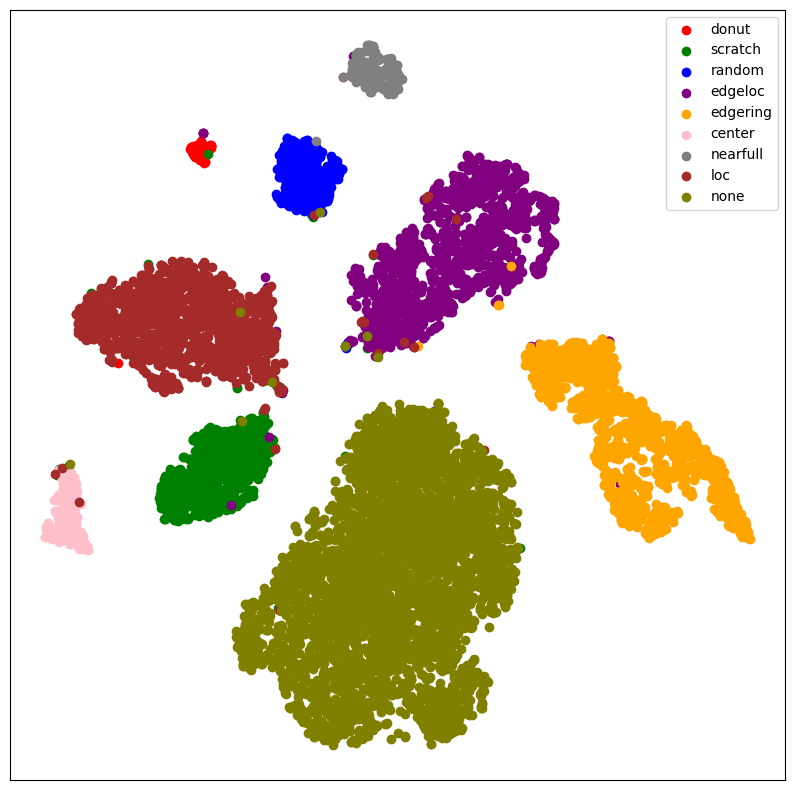

In [157]:
# Plotting the siamese generated embeddings in 2D.

tsne = TSNE(n_components=2, random_state=42)
embeddings_2D = tsne.fit_transform(embeddings.cpu())
labels = labels.cpu()

plt.figure(figsize=(10, 10))
colors = ['red', 'green', 'blue', 'purple', 'orange', 'pink', 'gray', 'brown', 'olive'] # list of colors for different classes
for i in range(len(colors)):
    plt.scatter(embeddings_2D[labels ==i, 0], embeddings_2D[labels==i, 1], c=colors[i], label=str(class_names[i]))
plt.legend()

plt.xticks([])
plt.yticks([])

plt.savefig('./gray_tsne_BCE_loss_2D_plot.png')

plt.show()

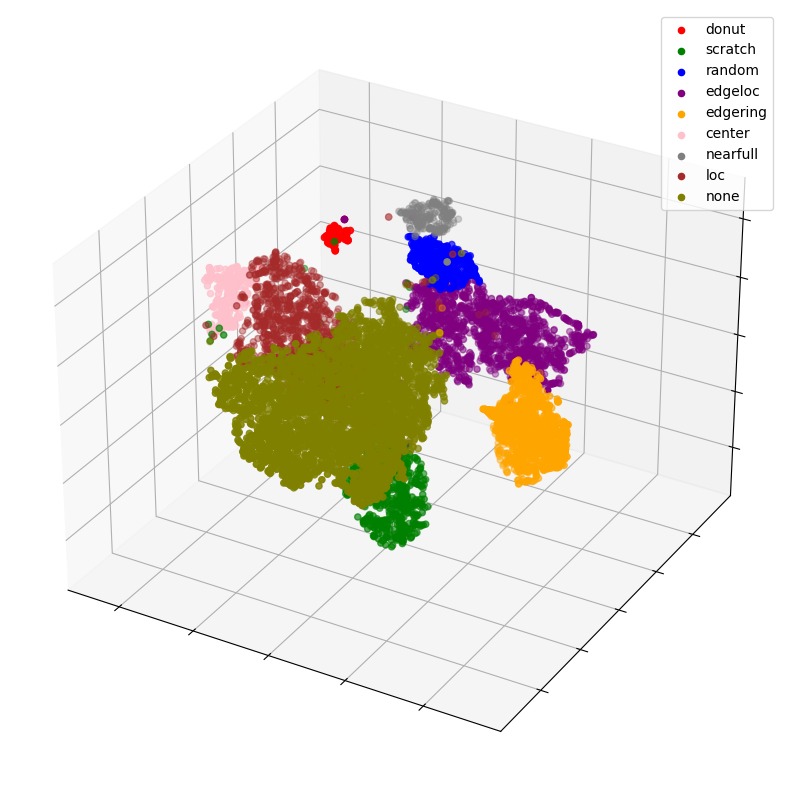

In [50]:
# Plotting the siamese generated embeddings in 3D

tsne = TSNE(n_components=3, random_state=42)
embeddings_2D = tsne.fit_transform(embeddings.cpu())
labels = labels.cpu()
# Plot the results in 3D
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
colors = ['red', 'green', 'blue', 'purple', 'orange', 'pink', 'gray', 'brown', 'olive'] # list of colors for different classes
for i in range(len(colors)):
    ax.scatter(embeddings_2D[labels==i, 0], embeddings_2D[labels==i, 1], embeddings_2D[labels==i, 2], c=colors[i], label=str(class_names[i]))
ax.legend()


# Remove x, y, and z tick labels, but keep the grid
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

# Save the plot as an image file
plt.savefig('./tsne_BCE_loss_3D_plot.png')

plt.show()

In [56]:
#Creating list of different class data for easy access.

datasets = [donut, scratch, random_, edgeloc, edgering, center, nearfull, loc, none]

In [57]:
#Function to plot list of images
def plot_ref_imgs(ref_img_lst):
    fig, axes = plt.subplots(nrows=1, ncols=9, figsize=(20, 10))

    for i, ax in enumerate(axes.flat):
        ax.imshow(ref_img_lst[i])
        ax.axis("off")
        ax.set_title(class_names[i])

    # adjust the spacing between the subplots
    fig.subplots_adjust(wspace=0.2)

    # display the figure
    plt.show()

In [58]:
to_tensor = transforms.ToTensor()

## Generating fingerprint vectors

In [59]:
# Function to generate fingerprint vector by comparing the test image with randomly picked image from each class.

def similarity_vec_gen(ip_img, data, model, label, print_plot = True):
    ref_images = {}
  
    ip_img = to_tensor(ip_img).view(1,1,64,64).to(device).float()
    
    ref_donut_img = data[0][int(np.random.choice(len(data[0]), size = 1))][0]
    ref_donut  = to_tensor(ref_donut_img).view(1,1,64,64).to(device).float() 
    sim0 = model(ip_img , ref_donut)
    ref_images[0] = ref_donut_img
    
    ref_scratch_img = data[1][int(np.random.choice(len(data[1]), size = 1))][0]
    ref_scratch  = to_tensor(ref_scratch_img).view(1,1,64,64).to(device).float()     
    sim1 = model(ip_img , ref_scratch)
    ref_images[1] = ref_scratch_img

    
    ref_random_img = data[2][int(np.random.choice(len(data[2]), size = 1))][0]
    ref_random  = to_tensor(ref_random_img).view(1,1,64,64).to(device).float()     
    sim2 = model(ip_img , ref_random)
    ref_images[2] = ref_random_img

    
    ref_edgeloc_img = data[3][int(np.random.choice(len(data[3]), size = 1))][0]
    ref_edgeloc  = to_tensor(ref_edgeloc_img).view(1,1,64,64).to(device).float()     
    sim3 = model(ip_img , ref_edgeloc)
    ref_images[3] = ref_edgeloc_img

    
    ref_edgering_img = data[4][int(np.random.choice(len(data[4]), size = 1))][0]
    ref_edgering  = to_tensor(ref_edgering_img).view(1,1,64,64).to(device).float()     
    sim4 = model(ip_img , ref_edgering)
    ref_images[4] = ref_edgering_img

    
    ref_center_img = data[5][int(np.random.choice(len(data[5]), size = 1))][0]
    ref_center  = to_tensor(ref_center_img).view(1,1,64,64).to(device).float()     
    sim5 = model(ip_img , ref_center)
    ref_images[5] = ref_center_img

    
    ref_nearfull_img = data[6][int(np.random.choice(len(data[6]), size = 1))][0]
    ref_nearfull  = to_tensor(ref_nearfull_img).view(1,1,64,64).to(device).float()     
    sim6 = model(ip_img , ref_nearfull)
    ref_images[6] = ref_nearfull_img

    
    ref_loc_img = data[7][int(np.random.choice(len(data[7]), size = 1))][0]
    ref_loc  = to_tensor(ref_loc_img).view(1,1,64,64).to(device).float()     
    sim7 = model(ip_img , ref_loc)
    ref_images[7] = ref_loc_img

    
    ref_none_img = data[8][int(np.random.choice(len(data[8]), size = 1))][0]
    ref_none  = to_tensor(ref_none_img).view(1,1,64,64).to(device).float()     
    sim8 = model(ip_img , ref_none)
    ref_images[8] = ref_none_img
    
    outputs = torch.cat((sim0, sim1, sim2, sim3, sim4, sim5, sim6, sim7, sim8), dim=0)
    
    similarity_feature_vector = outputs.detach().cpu().numpy().flatten()
    
    max_idx = np.argmax(similarity_feature_vector)
    
    if print_plot == True:
        print(f"The defect pattern belongs to class \033[1m'{class_names[max_idx]}'\033[0m with \033[1mlabel {max_idx}\033[0m with cosine similarity of \033[1m{similarity_feature_vector[max_idx]}\033[0m")
        print()
        print("The different randomly picked images from each class for comparision are :")
        plot_ref_imgs(ref_images)
        
        formatted_list = ["{:.10f}".format(num) for num in similarity_feature_vector]
        print(f"The similarity-based fingerprint vector w.r.t 9 different defect patterns :- \n \033[1m{str(formatted_list)}\033[0m")
    return  similarity_feature_vector , ref_images , max_idx

## mean similarity-based fingerprint vector.

In [64]:
"""
The function iterates and generates different similarity vectors w.r.t to different 
input image and returns a mean similarity feature and the predicted class label. 
"""
def mean_sim_vector(ip_img, data, model,label, mean_size =10, print_ = True):
    vectors =[]
    for i in range(mean_size):
        similarity_vector, _ , _= similarity_vec_gen(ip_img, data, model, label, print_plot = False)
        vectors.append(similarity_vector)
        
    mean_similarity_vec = np.mean(vectors, axis=0)
    idx_max = np.argmax(mean_similarity_vec)

    if print_ == True:
        print(f"The defect pattern belongs to class \033[1m'{label[idx_max]}'\033[0m with \033[1mlabel {idx_max}\033[0m and with similarity of \033[1m{mean_similarity_vec[idx_max]}\033[0m")
        print()
        formatted_list = ["{:.6f}".format(num) for num in mean_similarity_vec]
        print(f"Mean similarity feature vector for a input image w.r.t 9 different sets of defect patterns :- \n \033[1m{str(formatted_list)}\033[0m")
     
    return mean_similarity_vec , idx_max


In [68]:
#Predicting mean similarity feature vector and the class label for the given image.

mean_similarity_vector , class_label = mean_sim_vector(img, datasets, load_siamese_net,class_names, mean_size = 100)

The defect pattern belongs to class 'edgering' with label 4 and with similarity of 0.999106228351593

Mean similarity feature vector for a input image w.r.t 9 different sets of defect patterns :- 
 ['0.000000', '0.000000', '0.000002', '0.000078', '0.999106', '0.000000', '0.000000', '0.000055', '0.000899']


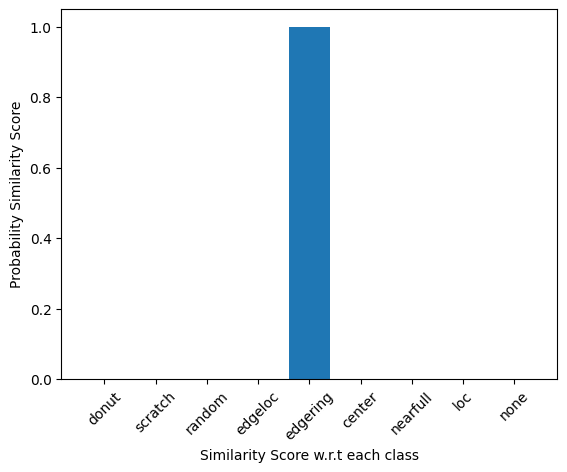

In [69]:
#Bar chart

plt.bar(class_names.keys(), mean_similarity_vector)
plt.xticks(list(class_names.keys()), class_names.values(), rotation=45)
plt.xlabel('Similarity Score w.r.t each class')
plt.ylabel('Probability Similarity Score')
#plt.title('Similarity score of input image w.r.t different classes')
plt.savefig('bar_chart.png', dpi=300, bbox_inches='tight')
plt.show()

## Model Evaluation

In [71]:
# The test data is not seen by the model during training.

test_data = donut_test + scratch_test + random_test + edgeloc_test + edgering_test + \
                  center_test + nearfull_test + loc_test + none_test
                                 
print(len(test_data))
random.shuffle(combined_data)

1032


100%|██████████| 1032/1032 [02:51<00:00,  6.01it/s]


Overall Accuracy: 0.8943798449612403
Class-wise Precision, Recall, F1-score:
               precision    recall  f1-score   support

       donut       0.67      0.67      0.67         9
     scratch       0.71      0.55      0.62        77
      random       0.82      0.93      0.87        40
     edgeloc       0.84      0.89      0.86       159
    edgering       0.94      0.97      0.95       145
      center       0.71      0.93      0.81        27
    nearfull       0.96      0.96      0.96        23
         loc       0.85      0.80      0.83       142
        none       0.97      0.97      0.97       410

    accuracy                           0.89      1032
   macro avg       0.83      0.85      0.84      1032
weighted avg       0.89      0.89      0.89      1032



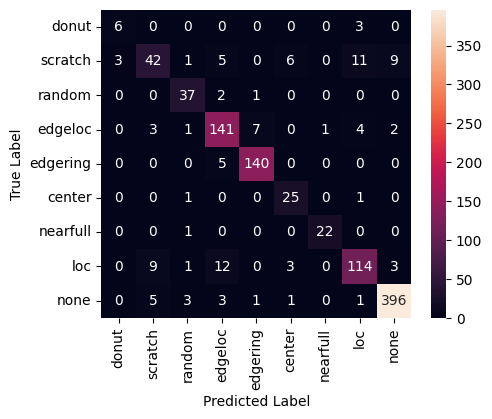

In [73]:
#Evaluating the predictions made by the model using performance metrics.

from sklearn.metrics import classification_report

def class_wise_report(test_dataset, data, model, label):
    y_true =[]
    y_pred =[]
    for i in tqdm(range(len(test_dataset))):
        image = test_dataset[i][0]
        image_label = test_dataset[i][1]
        _ , pred_label = mean_sim_vector(image, datasets, load_siamese_net ,class_names, mean_size = 10, print_ = False)

        y_true.append(image_label)
        y_pred.append(pred_label)
    
    accuracy = accuracy_score(y_true, y_pred)
    print('Overall Accuracy:', accuracy)
    
    class_names_str = [class_names[i] for i in range(len(class_names))]

    class_report = classification_report(y_true, y_pred, target_names=class_names_str)
    print('Class-wise Precision, Recall, F1-score:\n', class_report)
    
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize = (5,4))
    sns.heatmap(cm, annot = True , fmt ='d', xticklabels=class_names_str, yticklabels=class_names_str)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    
    plt.savefig('./Siamese_BCE_confusion_matrix.png')
    return accuracy, class_report, cm

accuracy, report, cm = class_wise_report(test_data, datasets, load_siamese_net, class_names)